## Project Description:

Welcome to your new project! You will have the opportunity to apply the knowledge and skills you've learned in class.

The tasks are divided into two parts, the first part is to create an image classification project that predicts a person's age based on their photograph. You will be utilizing the power of machine learning pipelines to streamline your workflow and effectively manage the different stages of this project, from data preprocessing to model training and evaluation.

In the second part is transfer learning where you'll use a [Vision Transformer (ViT)](https://huggingface.co/google/vit-base-patch16-224-in21k) model pre-trained on ImageNet-21k and fine-tune it on the [FastJobs/Visual_Emotional_Analysis](https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis) dataset for emotion recognition, with the final step being the publication of your trained model to the Hugging Face Model Hub.

Remember, the goal of this assignment is not just to build a model that makes accurate predictions, but also to understand the process of developing a machine-learning pipeline and the role each component plays in this process.

We encourage you to be creative, explore different strategies, and most importantly, have fun while learning. We can't wait to see the innovative solutions you come up with! Best of luck!

# Task 2: Transfer Learning for Emotion Recognition

### Step 1: Environment Setup

In this section, we start by installing the necessary packages and logging into Hugging Face's platform:
- `transformers`
- `datasets`
- `evaluate`
- `huggingface_hub`

In [ ]:
# Install necessary packages

# Put your code here:
%pip install transformers datasets evaluate

# ---- End of your code ----

After installing, use the Hugging Face's notebook login function to log into Hugging Face's platform. Execute the following commands in your cell:

In [ ]:
# Log into Hugging Face's platform
from huggingface_hub import notebook_login
notebook_login()
# ---- End of your code ----


### Step 2: Load the Dataset

Load the "FastJobs/Visual_Emotional_Analysis" dataset and split it into training and test sets with a test size of 0.2.

> **Note**: please assign to variable `emotion`

In [ ]:
from datasets import load_dataset

# Load the dataset from Hugging Face
from datasets import load_dataset
emotion = load_dataset("FastJobs/Visual_Emotional_Analysis", split="train")
emotion = emotion.train_test_split(test_size=0.2)

# Inspect the dataset
print(emotion)

# ---- End of your code ----


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 640
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 160
    })
})


**Label Mapping**

> **Note**: no need to change the code below! Just run it to map labels from the dataset.

In [ ]:
labels = emotion["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

### Step 3: Explore and Visualize the Dataset

In this step, you are required to visualize the first instance in the training dataset.

> **Note**: no need to change the code below! Just run it to visualize the dataset based on index.

In [ ]:
import matplotlib.pyplot as plt

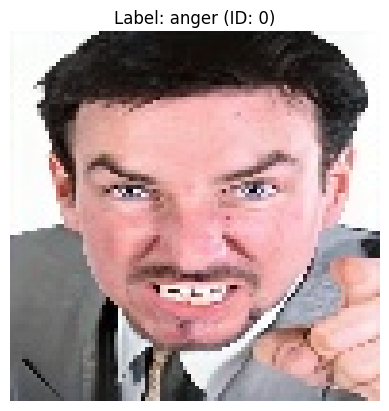

In [ ]:
import matplotlib.pyplot as plt

# Define the function to convert label index to label name
id2label_view = {str(i): label for i, label in enumerate(labels)}

# Use first training example
image = emotion['train'][0]['image'] # Explore image by index
label_id = str(emotion['train'][0]['label'])
label_name = id2label_view[label_id]

# Display the image and its corresponding label
plt.imshow(image)
plt.title(f'Label: {label_name} (ID: {label_id})')
plt.axis('off')
plt.show()

### Step 4: Preprocess the Data

You need to define the transformation function for image preprocessing and apply it to the dataset.

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])


In [ ]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [ ]:
emotion = emotion.with_transform(transforms)

### Step 5: Model Setup

In this step, define the model architecture with the pre-trained ViT model and load it.

In [ ]:
from transformers import AutoModelForImageClassification

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Step 6: Training Setup

Define the training arguments and instantiate the trainer.

In [ ]:
import evaluate

# Load accuracy metric

# Put your code here:

# ---- End of your code ----te

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model/emotion_classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=emotion["train"],
    eval_dataset=emotion["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

To use Hugging Face `Trainer` you need to install the `accelerate` library version `0.20.1` or later. It is used for performance enhancement on PyTorch.

If there are problems when using the Trainer after installing `accelerate` you can restart the Kernel

### Step 7: Train and Evaluate the Model

Now, you are ready to train the model and evaluate it on the test set.

In [ ]:
# Train the model
trainer.train()
# Put your code here:

# ---- End of your code ----

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: diwapraset02 (diwapraset02-indonesia-univercity-of-education). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,2.077700,2.058299,0.181250
2,2.013900,1.984950,0.268750
3,1.865400,1.858278,0.306250
4,1.704400,1.731358,0.393750
5,1.595700,1.625329,0.412500
6,1.501600,1.581810,0.381250
7,1.427900,1.532936,0.450000
8,1.347000,1.549079,0.425000
9,1.301900,1.466241,0.512500
10,1.236000,1.437496,0.500000


TrainOutput(global_step=150, training_loss=1.4532179832458496, metrics={'train_runtime': 734.5905, 'train_samples_per_second': 13.069, 'train_steps_per_second': 0.204, 'total_flos': 7.439631055847424e+17, 'train_loss': 1.4532179832458496, 'epoch': 15.0})

In [ ]:
eval_result = trainer.evaluate(eval_dataset=emotion["test"])

In [ ]:
accuracy_str = "{:.4f}".format(eval_result["eval_accuracy"])

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1729517001.a0c73928d8ac.6606.0:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

events.out.tfevents.1729516487.a0c73928d8ac.204.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

events.out.tfevents.1729517739.a0c73928d8ac.6606.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/diwa02/emotion_classification/commit/31f1497847604bff33e2203e381d559d09576805', commit_message='End of training', commit_description='', oid='31f1497847604bff33e2203e381d559d09576805', pr_url=None, repo_url=RepoUrl('https://huggingface.co/diwa02/emotion_classification', endpoint='https://huggingface.co', repo_type='model', repo_id='diwa02/emotion_classification'), pr_revision=None, pr_num=None)

### Step 8: Publishing the Trained Model

Finally, make sure to push your trained model to the Hugging Face Model Hub.

> **Note**: No need to change the code below! Just run to publish your model.

In [ ]:
%pip install gradio

In [ ]:
import gradio as gr
from gradio import components
from PIL import Image
from transformers import pipeline
import numpy as np

Once you've trained your model and pushed it to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

The following link is an example of what a trained model's page looks like: https://huggingface.co/aditira/emotion_classification. This is not your model, but rather an example of what your final result might resemble.

Remember, for this project you should push your output model to your own Hugging Face account. The link for your model will be different and should reflect your own username and model name.

In [ ]:
def predict_emotion(input_image):
    emotion_classifier = pipeline('image-classification', model='aditira/emotion_classification')
    results = emotion_classifier(input_image)
    output_dict = results[0]
    return output_dict


### Step 9:  Build an Interactive Application with Gradio

In this task, you will be building an interactive application using Gradio that will use your fine-tuned emotion recognition model along with another pretrained model ('`nateraw/vit-age-classifier`') to guess the emotion and age from an input image.

Please make sure to:
- Install the necessary package (`gradio`) for creating the web-based interface.
- Load your fine-tuned model as well as the pretrained model '`nateraw/vit-age-classifier`'.
- Define a function that will take an image as input and return the predicted emotion and age.
- Utilize Gradio to create an Interface (UI) for your function, allowing users to upload images and see the predicted emotion and age.

In [ ]:
def predict_age(input_image):
    classifier = pipeline('image-classification', model='nateraw/vit-age-classifier')
    results = classifier(input_image)
    output_dict = results[0]
    return output_dict


#### Submisssion

![Upload colab](https://storage.googleapis.com/rg-ai-bootcamp/project-3-pipeline-and-gradio/upload-colab.png)

You need to submit screenshot of your Gradio's app. In Google Colab you can just use the "Folder" sidebar and click the upload button. Make sure your screenshot match below requirements:

- Image name screenshot is `submission.jpg`
- You should upload a person's image to that app
- The score should be included at the screenshot

In [ ]:
# Put your code here:
def predict_emotion_and_age(input_image):
    input_image = Image.fromarray(np.uint8(input_image)).convert('RGB')

    emotion_result = predict_emotion(input_image)
    age_result = predict_age(input_image)

    return emotion_result, age_result

# ---- End of your code ----

In [ ]:
import shutil
shutil.rmtree('/root/.cache/gradio', ignore_errors=True)
print("Gradio cache cleared.")

In [ ]:
import gradio as gr

image = gr.Image()  # Removed shape argument
iface = gr.Interface(fn=predict_emotion_and_age, inputs=image, outputs=[gr.JSON(), gr.JSON()])
iface.launch(debug=True)  # Set share=True to create a public link


config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/197 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Submit Method
question_id = "01_interactive_application_with_gradio"
submit_image(student_id, question_id, './submission.png')

'Assignment successfully submitted'

> Note: If your submission for Task-2 did not run (After you run it never changes from "*" to a number), stop the Code block that's running the Gradio app, then the submission will run. To stop the Code block, you can click on the Code block and then click the stop button.

Example of Expected Output:

![gradio-result](https://storage.googleapis.com/rg-ai-bootcamp/project-4-transfer-learning/gradio_emotion_age_app.png)